# 采用Fashion-MNIST 数据集

In [17]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
import time
from d2l import torch as d2l
from IPython import display


## 下载数据集

In [2]:
# 通过ToTensor实例将图像数据从PIL类型转换为32位浮点数格式
# 并除以255进行归一化
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data/", 
                                                train=True,
                                               transform=trans,
                                               download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data/",
                                              train=False,
                                              transform=trans,
                                              download=True)

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

## 可视化数据集

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

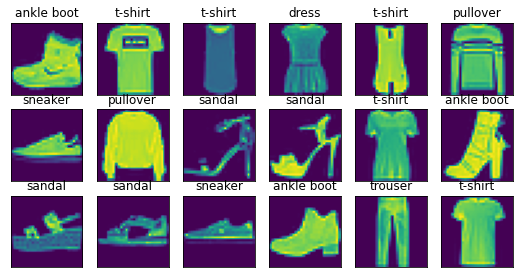

In [5]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18,28,28),3,6,titles=get_fashion_mnist_labels(y))

In [6]:
batch_size = 64
def get_dataloader_workers():
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers())
start = time.time()
for X, y in train_iter:
    continue

f'{time.time()-start:2f}sec'

'4.601574sec'

In [7]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

# softmax 回归从零开始实现

In [8]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [9]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs),
                 requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## 模型

In [10]:
# x (bach_size, 10)
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

# range(len(y_hat)) -> (0,1,2,3.....batch_size-1)
# 通过y可知当前真实的类别i，可以取得预测的yi
def cross_entropy(y_hat, y):
    # 高级索引
    return -torch.log(y_hat[range(len(y_hat)), y])


## 预测

In [11]:

# 计算预测正确的数量
def accuracy(y_hat, y):
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        # argmax会返回每行最大值的下标
        y_hat = y_hat.argmax(axis=1)
    # 将y_hat的类型转化为和y一样（即int） 然后和y作比较
    cmp = y_hat.type(y.dtype) == y
    # 将布尔类型的cmp转化为和y一样的类型（即int）
    # 进行求和可以得到预测正确的个数
    return float(cmp.type(y.dtype).sum())

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        # 将list打包为tuple
        self.data = [a + float(b) for a,b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

# 计算在指定数据集上的精度
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        # 将网络转化为评估模式（不再计算梯度
        net.eval()
    # 累加器 2 -> 放两种数据 即预测正确数量 样本总数
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


## 训练

In [12]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if (isinstance(net, torch.nn.Module)):
        net.train()
    metric = Accumulator(3)
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if (isinstance(updater, torch.optim.Optimizer)):
            updater.zero_grad()
            l.sum().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), 
                   accuracy(y_hat, y), y.numel())
        # 返回训练损失和训练精度
    return metric[0]/metric[2], metric[1]/metric[2]


In [13]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [14]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs,updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1 , train_metrics + (test_acc, ))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <=1 and train_acc > 0.7, train_acc
    assert test_acc <=1 and test_acc > 0.7, test_acc
    

In [15]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W,b], lr, batch_size)


RuntimeError: DataLoader worker (pid(s) 16020, 1476, 15168) exited unexpectedly

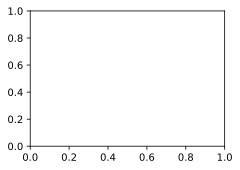

In [18]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)